# Actor Critic on Crude Oil daily data

In this notebook a fully connected DQN model is trained on the crude oil daily dataset, enriched with the various tecnical indicators and the crude oil implied volatility index `OVX`.

The importance of **implied volatility** for market participants stems from the fact that it is one of the only data that is **forward-looking**. This is because market participants always trade contracts with an expiration date later in time. 

The goal of this notebook is to see how (if it is possible) a A2C trading agent can leverage this kind of data to learn a profitable trading strategy. 

In [ ]:
#@title **Install externals libraries** {display-mode:'form'}
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title **Imports** {display-mode: 'form'}

import gym
from gym import spaces
from gym.utils import seeding

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from enum import Enum
import matplotlib.pyplot as plt

from stable_baselines3 import A2C
from stable_baselines3.dqn.policies import DQNPolicy

from gym_anytrading.envs.future_env import FuturesEnv

In [ ]:
np.random.seed(0)

In [ ]:
df_path = 'data/CL_daily_adj.csv'

# Preprocessing

The preprocessing phase consist in the following phases:

- addition of cyclical features for the time-related variables
- standardization of the data

In [ ]:
def add_cyclical_features(df):
    df['date'] = pd.to_datetime(df.index.copy(), format='%Y-%m-%d')
    df['day_sin'] = df['date'].apply(lambda x: np.sin(x.day * (2. * np.pi / 30)))
    df['day_cos'] = df['date'].apply(lambda x: np.cos(x.day * (2. * np.pi / 30)))
    df['month_sin'] = df['date'].apply(lambda x: np.sin(x.month * (2. * np.pi / 12)))
    df['month_cos'] = df['date'].apply(lambda x: np.cos(x.month * (2. * np.pi / 12)))
    df = df.drop('date', axis=1)
    return df

In [ ]:
cl_df = pd.read_csv(path, parse_dates=True)
cl_df = cl_df.set_index('Date')
cl_df = add_cyclical_features(cl_df)
sc = StandardScaler()
cols, cl_index = cl_df.columns, cl_df.index
cl_df = pd.DataFrame(sc.fit_transform(cl_df), columns=cols, index=cl_index)
window_size = 21
training_portion = 0.8
episodes = 300

train_cl_df = cl_df[0:int(np.floor(len(cl_df) * training_portion))]
test_cl_df = cl_df[int(np.floor(len(cl_df) * training_portion)):]

env = FuturesEnv(df=train_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(train_cl_df)))

# Training

Only 80% of the total data is used during the training phase. That's because we want to avoid the model simply memorizing the dataset (overfitting) and obtaining a model that is generalized well in all market situations.

The A2C model is a fully connected neural network with 4 layers with 256, 128, 128, 64 neurson respectvely, the neural network will be given as input the daily data of the previous month (21 days).

In [8]:
policy_kwargs = {'net_arch':[256, 128, 128, 64]}
model = A2C("MlpPolicy", 
            env, 
            verbose=1,
            seed=0,
            policy_kwargs=policy_kwargs
            )
model.learn(total_timesteps=episodes*len(train_cl_df))

Output streaming troncato alle ultime 5000 righe.
|    value_loss         | 10.8     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.91e+03 |
|    ep_rew_mean        | 1.04e+03 |
| time/                 |          |
|    fps                | 478      |
|    iterations         | 153700   |
|    time_elapsed       | 1607     |
|    total_timesteps    | 768500   |
| train/                |          |
|    entropy_loss       | -0.0932  |
|    explained_variance | -0.607   |
|    learning_rate      | 0.0007   |
|    n_updates          | 153699   |
|    policy_loss        | -0.0365  |
|    value_loss         | 5.46     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.91e+03 |
|    ep_rew_mean        | 1.04e+03 |
| time/                 |          |
|    fps                | 478      |
|    iterations         |

# Testing Results

Now that the model has been trained, let's test its performance on the testing data (out of sample data).

In [12]:
test_cl_df

,open,high,low,close,MA,Smoothing Line,MA.1,Smoothing Line.1,Volume,Volume MA,...,RSI,RSI-based MA,open_ovx,high_ovx,low_ovx,close_ovx,day_sin,day_cos,month_sin,month_cos
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-10,-0.766621,-0.781867,-0.772128,-0.805764,-0.557000,-0.549930,-0.471244,-0.459655,1.406739,2.431131,...,-1.559446,-1.757536,0.009844,-0.041668,0.066581,0.033422,1.208730,-0.700735,0.020215,-1.379204
2019-06-11,-0.801041,-0.815611,-0.778118,-0.805340,-0.560543,-0.553209,-0.477260,-0.465408,1.180781,2.326137,...,-1.555212,-1.905771,-0.058059,-0.068138,0.025882,0.009896,1.034021,-0.938723,0.020215,-1.379204
2019-06-12,-0.817613,-0.857370,-0.871809,-0.895611,-0.564819,-0.556685,-0.486411,-0.471740,1.912568,2.336176,...,-1.942565,-2.014049,0.080010,0.161411,0.158462,0.248979,0.813134,-1.135560,0.020215,-1.379204
2019-06-13,-0.901326,-0.840498,-0.863252,-0.847297,-0.568856,-0.560344,-0.495430,-0.478589,2.724882,2.400899,...,-1.475328,-1.996319,0.100381,0.046419,0.158462,0.166914,0.555723,-1.282645,0.020215,-1.379204
2019-06-14,-0.854158,-0.860322,-0.829883,-0.837549,-0.572753,-0.564205,-0.504142,-0.486233,0.829564,2.409222,...,-1.383611,-1.999970,0.158099,0.095019,0.262676,0.239678,0.273038,-1.373548,0.020215,-1.379204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-07,1.989538,1.981769,1.969726,1.997738,0.836642,0.810659,1.512815,1.505220,-0.502093,-0.753493,...,1.147665,0.698856,0.719996,0.467330,0.527836,0.403261,1.391423,0.149912,0.020215,-1.379204
2022-06-08,2.018859,2.100717,2.062134,2.112167,0.850380,0.823929,1.526957,1.512118,-0.540445,-0.777848,...,1.412969,0.814407,0.617010,0.384016,0.447671,0.320649,1.391423,-0.144257,0.020215,-1.379204
2022-06-09,2.131043,2.081314,2.125878,2.086739,0.863510,0.837379,1.542079,1.520712,-0.802194,-0.815076,...,1.286316,0.899154,0.504970,0.295061,0.364424,0.293294,1.329625,-0.431998,0.020215,-1.379204


In [9]:
testing_env = FuturesEnv(df=test_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(test_cl_df)))

In [10]:
obs = testing_env.reset()
i = 0

for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, rewards, dones, info = testing_env.step(action)

    print(f'step: {i}, reward: {rewards}, account_value: {testing_env.get_account_value()}, action: {action}, position: {info["position"]}')

    if dones:
      break

    i += 1

step: 0, reward: 0, account_value: 1000000, action: 1, position: -1
step: 1, reward: -0.05091026213379323, account_value: 1000000, action: 1, position: -1
step: 2, reward: -0.19451114426483523, account_value: 1000000, action: 1, position: -1
step: 3, reward: -0.2502566252767778, account_value: 1000000, action: 1, position: -1
step: 4, reward: -0.3344001866922833, account_value: 1000000, action: 1, position: -1
step: 5, reward: -0.31401870592553166, account_value: 1000000, action: 1, position: -1
step: 6, reward: -0.2857654423578625, account_value: 1000000, action: 1, position: -1
step: 7, reward: -0.25090189532880725, account_value: 1000000, action: 1, position: -1
step: 8, reward: -0.30672489957018245, account_value: 1000000, action: 1, position: -1
step: 9, reward: -0.2981476706445037, account_value: 1000000, action: 1, position: -1
step: 10, reward: -0.2870105873892981, account_value: 1000000, action: 1, position: -1
step: 11, reward: -0.24443038107836637, account_value: 1000000, ac

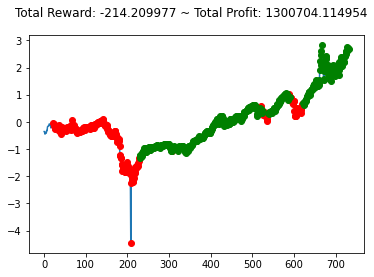

In [13]:
plt.cla()
testing_env.render_all()

> As we can see the model performance are positive, though it doesn't outperform the buy and hold strategy in terms of returns. 